In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install pyunpack
!pip install patool

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=f07d60ff94846abbd02b1154aeee4e1f713304d5a9d0986a6b133d67792b3a65
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack
     |████████████████████████████████| 81kB 3.1MB/s 


In [0]:
from pyunpack import Archive

In [5]:
# for each ".7z" file
for file_name in ["/content/drive/My Drive/train.7z", "/content/drive/My Drive/test.7z"]:

    # extracting all the files 
    print('Extracting all the files now...') 
    a = Archive(file_name)
    a.extractall("/content")
    print('Done!')

Extracting all the files now...
Done!
Extracting all the files now...
Done!


---

In [0]:
# Author 
#  - Name:   Pablo Leo Muñoz
#  - Email:  pabloleo96@gmail.com
#  - Github: https://github.com/pabloleo-96

In [0]:
# Note: The model was trained using tensorflow==1.15.0 on its GPU version

In [0]:
# data handling
import pandas as pd

# numerical operations
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

# deep learning
from tensorflow.keras.layers import Dense, Dropout, Input, CuDNNLSTM, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [0]:
# make plots bigger
plt.rcParams['figure.figsize'] = [12, 8]

In [0]:
# load ".csv" into memory
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [9]:
# check dimensions of the training/test dataset
n_samples_train, n_variables_train = df_train.shape
n_samples_test, n_variables_test = df_test.shape

# show info
print("There are {} samples in the training set with {} variables".format(n_samples_train, n_variables_train))
print("There are {} samples in the test set with {} variables".format(n_samples_test, n_variables_test))

There are 12000 samples in the training set with 261 variables
There are 12000 samples in the test set with 260 variables


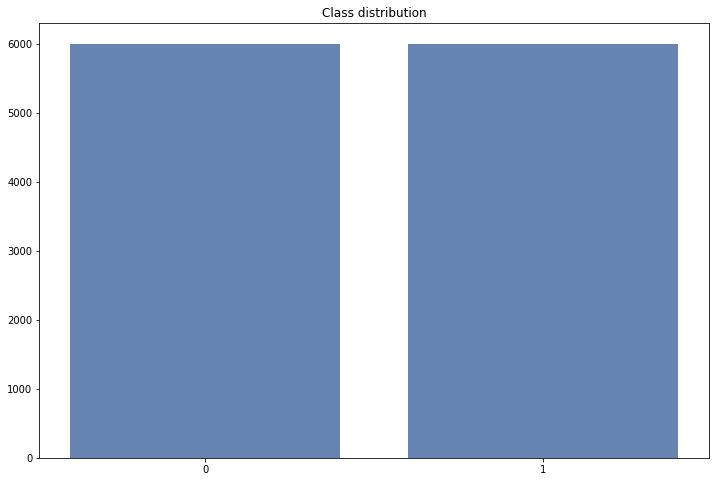

In [11]:
# chech if the classes are balanced
uniques, counts = np.unique(df_train.iloc[:,-1].values, return_counts = True)

# show a barplot
plt.bar(uniques, counts, color = (0,0.2,0.5,.6))
plt.xticks(uniques)
plt.title("Class distribution")
plt.show()

In [0]:
# both classes are balanced, therefore there is no need to use any balancing technique

In [0]:
def check_na(df):
    """
    Function that takes as input a dataframe and shows information
    about the amount of missing values on each variable
    """
    
    # get a mask containing whetere there ar NA's
    na_mask = df.isna()
    
    # get the number of NA's on each variable
    na_vars = np.sum(na_mask, axis = 0)
    
    print("There are {} variables with missing values".format(np.sum(na_vars > 0)))

In [13]:
# check if there are missing values
check_na(df_train)
check_na(df_test)

There are 0 variables with missing values
There are 0 variables with missing values


In [0]:
# none of the variables have missing values, therefore there is no need to use any imputting method

In [0]:
# plot a 'real' and 'synthetic' time series
synth = df_train[df_train["class"] == 0].sample()
real = df_train[df_train["class"] == 1].sample()

# get only the features and generate the cumulative sum of daily returns
synth_sum = np.cumsum(synth.iloc[:,:-1], axis = 1)
real_sum = np.cumsum(real.iloc[:,:-1], axis = 1)

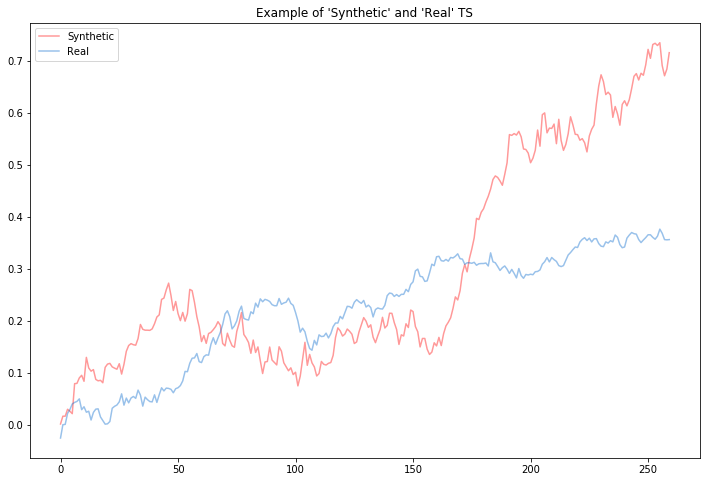

In [16]:
# plot the synthetic and the real one
plt.plot(synth_sum.values[0], color = (1,0,0,.4))
plt.plot(real_sum.values[0], color = (0,0.4,0.8,.4))
plt.title("Example of 'Synthetic' and 'Real' TS")
plt.legend(["Synthetic", "Real"])
plt.show()

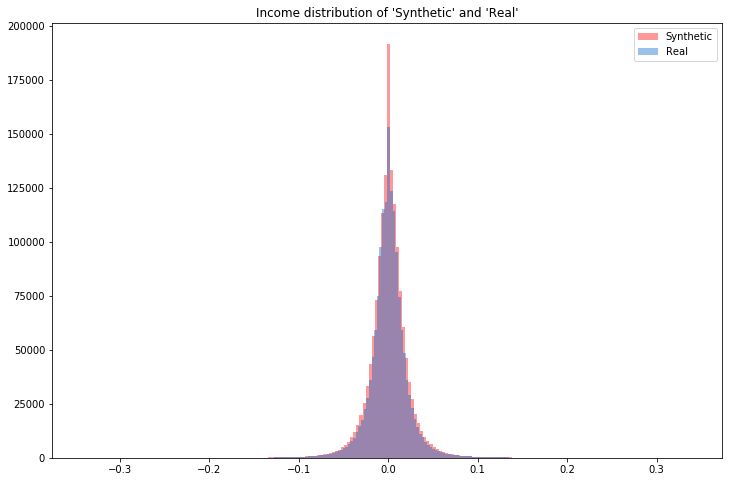

In [0]:
# plot the distribution of raw daily returns synthetic and real
plt.hist(df_train[df_train["class"] == 0].values[:,:-1].flatten(), bins = 200, color = (1,0,0,.4))
plt.hist(df_train[df_train["class"] == 1].values[:,:-1].flatten(), bins = 200, color = (0,0.4,0.8,.4))
plt.title("Income distribution of 'Synthetic' and 'Real'")
plt.legend(["Synthetic", "Real"])
plt.show()

In [0]:
# as one can see, the distribution of 'synthetic' and 'real' values look both 
# comes from a normal distribution with a mean around 0, a std around 0.1 and 
# a high kurtosis, this might indicate that they both come from the same 
# distribution and will probably be hard to differenciate

---

In [0]:
# split our dataset into training / validation
x_train, x_val, y_train, y_val = train_test_split(df_train.iloc[:,:-1].values, 
                                                  df_train.iloc[:,-1].values, 
                                                  test_size = 0.2,
                                                  shuffle = True)

In [0]:
# generate the time series (cumulative sum)
x_train = np.cumsum(x_train, axis = 1)
x_val = np.cumsum(x_val, axis = 1)

In [0]:
def scale_ts(x):
    """
    Function that scales the time series in the range [0-1]
    """
    
    # list holding the data
    x_scaled = []
    
    # calculate the scaled version
    for ts in x:
        x_scaled.append(((ts - ts.min()) / (ts.max() - ts.min())))
    
    # return a numpy array
    return np.array(x_scaled)

In [0]:
# scale both, train and test
x_train = scale_ts(x_train)
x_val = scale_ts(x_val)

In [0]:
def generate_structure(x, y = None, n_steps = 20):
    """
    Function that generates the correct structure to be used
    in the RNN with a given timesteps (n_steps)
    """
    
    # list that will store the new data
    x_lstm = []
    y_lstm = []

    # get the shape of the training structure
    n_samples, n_vars = x.shape
    
    # iterate over each sample and each time step
    for j in range(n_samples):
        for i in range(n_steps, n_vars):
            # append current ts and the correspoding label
            x_lstm.append(x[j, i-n_steps:i])
            
            # check if 'y' is specified in the input
            if y is not None:
                y_lstm.append(y[j])
            
    # convert to numpy arrays and return them
    if y is not None:
        return np.array(x_lstm), np.array(y_lstm)
    else:
        return np.array(x_lstm)

In [0]:
# number of steps
n_steps = 100

# generate correct structure
x_train_lstm, y_train_lstm = generate_structure(x_train, y_train, n_steps = n_steps)
x_val_lstm, y_val_lstm = generate_structure(x_val, y_val, n_steps = n_steps)

In [0]:
# expand 1 dimension
x_train_lstm = np.expand_dims(x_train_lstm, axis = 2)
x_val_lstm = np.expand_dims(x_val_lstm, axis = 2)

In [29]:
# generate the structure of the Recurrent Neural Network
x_in = Input(shape = (x_train_lstm.shape[1], 1))

# Cuda implementation (GPU) of LSTM
x = CuDNNLSTM(units = 40, kernel_initializer = "he_normal", recurrent_initializer = "he_normal", return_sequences = False)(x_in)
x = Dropout(0.2)(x) # dropout to avoid overfitting

# Fully Connected
x = Dense(32)(x)
x = Dropout(0.2)(x)

# Fully Connected
x_out = Dense(1, activation = "sigmoid")(x)

# model
model = Model(x_in, x_out)

# show the info summary
model.summary()

# parameters
optimizer = Adam(lr = 1e-3)
metrics = ["accuracy"]
loss = "binary_crossentropy"

# Compiling the RNN
model.compile(optimizer = optimizer, loss = loss)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 40)                6880      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1312      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,225
Trainable params: 8,225
Non-trainable params: 0
_________________________________________________________

In [0]:
# checkpoint to save best model
checkpoint = ModelCheckpoint("best_model.h5", save_best_only = True, monitor = "val_loss", verbose = 1, mode = "min")

# callback to reduce the learning rate on the training process
lr_reducer = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, verbose = 1, min_lr = 1e-7)

# list containing the callbacks
callbacks = [checkpoint, lr_reducer]

In [31]:
# Fitting the RNN to the Training set
model.fit(x_train_lstm, y_train_lstm,
          epochs = 10,
          verbose = 1,
          callbacks = callbacks,
          shuffle = False,
          batch_size = 512,
          validation_data = (x_val_lstm, y_val_lstm),
          use_multiprocessing = True)

Train on 1536000 samples, validate on 384000 samples
Epoch 1/10
1535488/1536000 [============================>.] - ETA: 0s - loss: 0.6981
Epoch 00001: val_loss improved from inf to 0.69308, saving model to best_model.h5
1536000/1536000 [==============================] - 62s 41us/sample - loss: 0.6980 - val_loss: 0.6931
Epoch 2/10
1534976/1536000 [============================>.] - ETA: 0s - loss: 0.6937
Epoch 00002: val_loss improved from 0.69308 to 0.69294, saving model to best_model.h5
1536000/1536000 [==============================] - 63s 41us/sample - loss: 0.6937 - val_loss: 0.6929
Epoch 3/10
1534464/1536000 [============================>.] - ETA: 0s - loss: 0.6933
Epoch 00003: val_loss did not improve from 0.69294
1536000/1536000 [==============================] - 61s 39us/sample - loss: 0.6933 - val_loss: 0.6930
Epoch 4/10
1534464/1536000 [============================>.] - ETA: 0s - loss: 0.6933
Epoch 00004: val_loss did not improve from 0.69294
1536000/1536000 [=================

In [32]:
# load best model (lowest validation loss)
model = load_model("best_model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
# predict the validation samples
y_pred_prob = model.predict(x_val_lstm, 
                            batch_size = 1024, 
                            verbose = 1, 
                            use_multiprocessing = True)

384000/384000 [==============================] - 4s 12us/sample


In [0]:
# get the individual predicitons 
probs = []

# calculate the 'jump' size
jump_size = x_train.shape[1] - n_steps

# iterate over each timestep
for i in range(0, y_pred_prob.shape[0], jump_size):
    probs.append(np.mean(y_pred_prob[i:i+jump_size]))

# convert to numpy array
probs = np.array(probs)

In [0]:
# convert probabilities to integer predictions (0/1)
y_pred = (probs > 0.5).astype(np.int)

In [51]:
# generate confusion matrix and the corresponding AUC
print("Accuracy: {}".format(np.sum(y_val == y_pred)/len(y_val)))
print("Confusion matrix: \n{}".format(confusion_matrix(y_val, y_pred)))
print("ROC-AUC Score: {}".format(roc_auc_score(y_val, probs)))
print("ROC-AUC Score (binary): {}".format(roc_auc_score(y_val, y_pred)))

Accuracy: 0.5145833333333333
Confusion matrix: 
[[ 219  963]
 [ 202 1016]]
ROC-AUC Score: 0.5140132224194889
ROC-AUC Score (binary): 0.5097167696064948


In [0]:
# the results show that our model is not correctly predicting almost any of the time series
# but that is be because the model is not cappable of finding any pattern in the data
# that separates both groups, despite that, this model will be used to predict test samples
# although the predictions are expected to not correctly differenciate between 'real' and
# 'synthetic' ones

---

In [0]:
# generate time sereis
x_test = np.cumsum(df_test.values, axis = 1)

In [0]:
# scale time series
x_test = scale_ts(x_test)

In [0]:
# generate correct structure
x_test_lstm = generate_structure(x_test, None, n_steps)

In [0]:
# expand last dimension
x_test_lstm = np.expand_dims(x_test_lstm, axis = 2)

In [57]:
# predict the test samples
y_pred_test = model.predict(x_test_lstm,
                            batch_size = 1024, 
                            verbose = 1, 
                            use_multiprocessing = True)

1920000/1920000 [==============================] - 22s 11us/sample


In [0]:
# get the individual predicitons 
probs_test = []

# calculate the 'jump' size
jump_size = x_test.shape[1] - n_steps

# iterate over each timestep
for i in range(0, y_pred_test.shape[0], jump_size):
    probs_test.append(np.mean(y_pred_test[i:i+jump_size]))

# generate numpy array
probs_test = np.array(probs_test)

In [0]:
# create results dataframe
df_test_pred = pd.DataFrame(probs_test)

# export to .csv
df_test_pred.to_csv("submission.csv", header = False, index = False)